## Introduction
The suicide rate in lots of countries have been quite high for many years, including the developing and developed countries. At the begining, we'll see the suicide rate of sex, and then the age and generation. Next we'll plot the rank of suicide rate, it's clearly to understand the distribution of the suicide rate. Finally, we'll find out the key factors of high suicide rate.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd
from scipy import stats
import pycountry
import geopandas

Let's see how many csv files are in this topic.


In [2]:
print(os.listdir('../input'))

['master.csv']


Only one file in this topic. take a look at the dataset.

In [3]:
filename = "../input/master.csv"
df = pd.read_csv(filename)
print(df.head())

   country  year       ...        gdp_per_capita ($)       generation
0  Albania  1987       ...                       796     Generation X
1  Albania  1987       ...                       796           Silent
2  Albania  1987       ...                       796     Generation X
3  Albania  1987       ...                       796  G.I. Generation
4  Albania  1987       ...                       796          Boomers

[5 rows x 12 columns]


Rename the columns.

In [4]:
df.rename(columns={"suicides/100k pop":"suicides_pop","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($) ":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)
print(df.columns)

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_pop', 'country-year', 'HDI_for_year', 'gdp_for_year',
       'gdp_per_capita', 'generation'],
      dtype='object')


Rearrange the dataset.

In [5]:
df["gdp_for_year"] = df["gdp_for_year"].str.replace(",","").astype(np.int64)
df["age"] = df["age"].str.replace("5-14 years","05-14 years")

Let's see the performance of sex. 

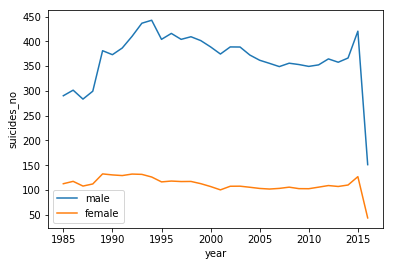

In [6]:
df_men = df[df.sex == "male"]
df_women = df[df.sex == "female"]
sns.lineplot(df_men.year, df.suicides_no, ci = None)
sns.lineplot(df_women.year, df.suicides_no, ci = None)
plt.legend(["male", 'female'])
plt.show()

No matter which year it is, the suicides number of male are about three times higher than of female. How about the age?

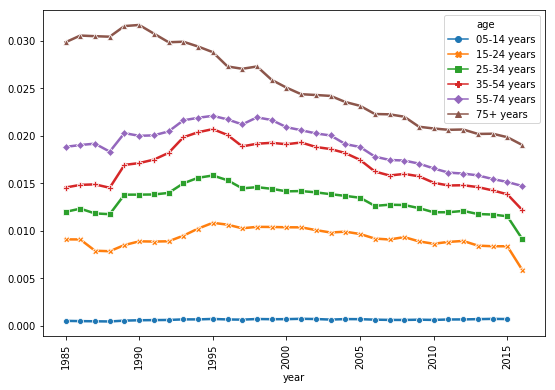

In [7]:
df_age = df.groupby(["year","age"])["suicides_no", "population"].sum()
df_reset = df_age.copy().reset_index()
plt.figure(figsize=(9,6))
sns.lineplot("year", df_reset.suicides_no*100/df_reset.population, hue = "age",
             data = df_reset, linewidth = 2.5, style = "age", markers=True
            , dashes=False)
plt.xticks(rotation = 90)
plt.show()

Obviously, the suicide rate is getting higher when the age is higher. That is, age is a factor of suicide. 

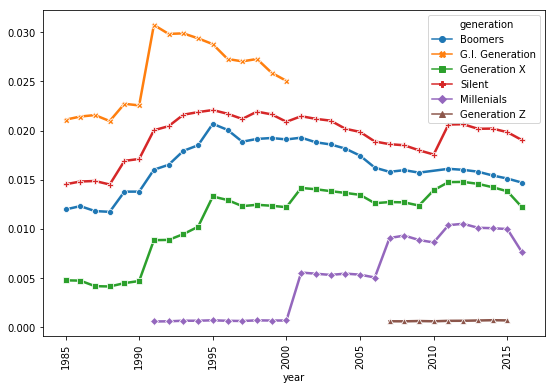

In [8]:
df_generation = df.groupby(["year", "generation"])["suicides_no", "population"].sum()
df_generation_reset = df_generation.copy().reset_index()
plt.figure(figsize=(9,6))
sns.lineplot("year", df_generation_reset.suicides_no*100/df_generation_reset.population, hue = "generation", 
            data = df_generation_reset, linewidth = 2.5, style = "generation", markers=True
            , dashes=False)
plt.xticks(rotation = 90)
plt.show()

Before 2000, we can see that the highest suicide rate is G.I. generation, and this generation is also known as WW2 generation. They suffered from the worldwide great depression before WW2, at this time, the income, profit, taxes are decreased seriously, so this generation experienced economic and social turmoil.

Did this kind of social impact affect the suicide rate of G.I. generation? Compare to the Silent generation after 2000, the suicide rate is not that high. 

Interestingly, the suicide rate of Generation X and Millenials increase step by step. Besides, the suicide rate increases rapidly once the average age of generation is over 20. Does it mean that the suicide rate of young persons rise when they are independent of their parents? In other words, healthy family is helpful to the suicide rate. Let's take a look.

We arange the country list and see how many countries are in the dataset, then calculate the suicide rate of countries.

In [9]:
df1 = df.groupby("country")["suicides_no"].sum()
country_name = list(df1.index.get_level_values(0))
len(country_name)

101

We'll map the suicide rate afterward, so we need to transfer the country name into country code.
We choose alpha3 country code.
-------ISO 3166-1 alpha-3 codes are three-letter country codes defined in ISO 3166-1, part of the ISO 3166 standard published by the International Organization for Standardization (ISO), to represent countries, dependent territories, and special areas of geographical interest. 

In [10]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

Double check country name if the name in country list are not the same.  

In [11]:
country_not_in_list = [i for i in country_name[:] if i not in countries.keys()]
country_not_in_list

['Czech Republic',
 'Macau',
 'Republic of Korea',
 'Saint Vincent and Grenadines']

We found that there are four country names are different, so we rename these names.

In [12]:
df.replace("Republic of Korea", "Korea, Republic of", inplace = True)
df.replace('Czech Republic', "Czechia", inplace = True)
df.replace('Macau', 'Macao', inplace = True)
df.replace('Saint Vincent and Grenadines', "Saint Vincent and the Grenadines", inplace = True)

Before ploting the suicide rate of each countries, we calcuate the suicide rate for each year, and then take the average of number as rate.

In [13]:
df_suino = df.groupby(["country","year"])["suicides_no"].sum()
df_sum = df_suino.sort_index(ascending=True)[:] * 100

df_pop = df.groupby(["country","year"]).population.sum()
df_pop_sum = df_pop.sort_index(ascending=False)[:]

df_total = df_sum / df_pop_sum
df_total.head(10)

country  year
Albania  1987    0.002694
         1988    0.002279
         1989    0.002426
         1992    0.001665
         1993    0.002600
         1994    0.001755
         1995    0.003031
         1996    0.003027
         1997    0.005710
         1998    0.005112
dtype: float64

In [14]:
country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]

OK! We can plot the top 20 countries.

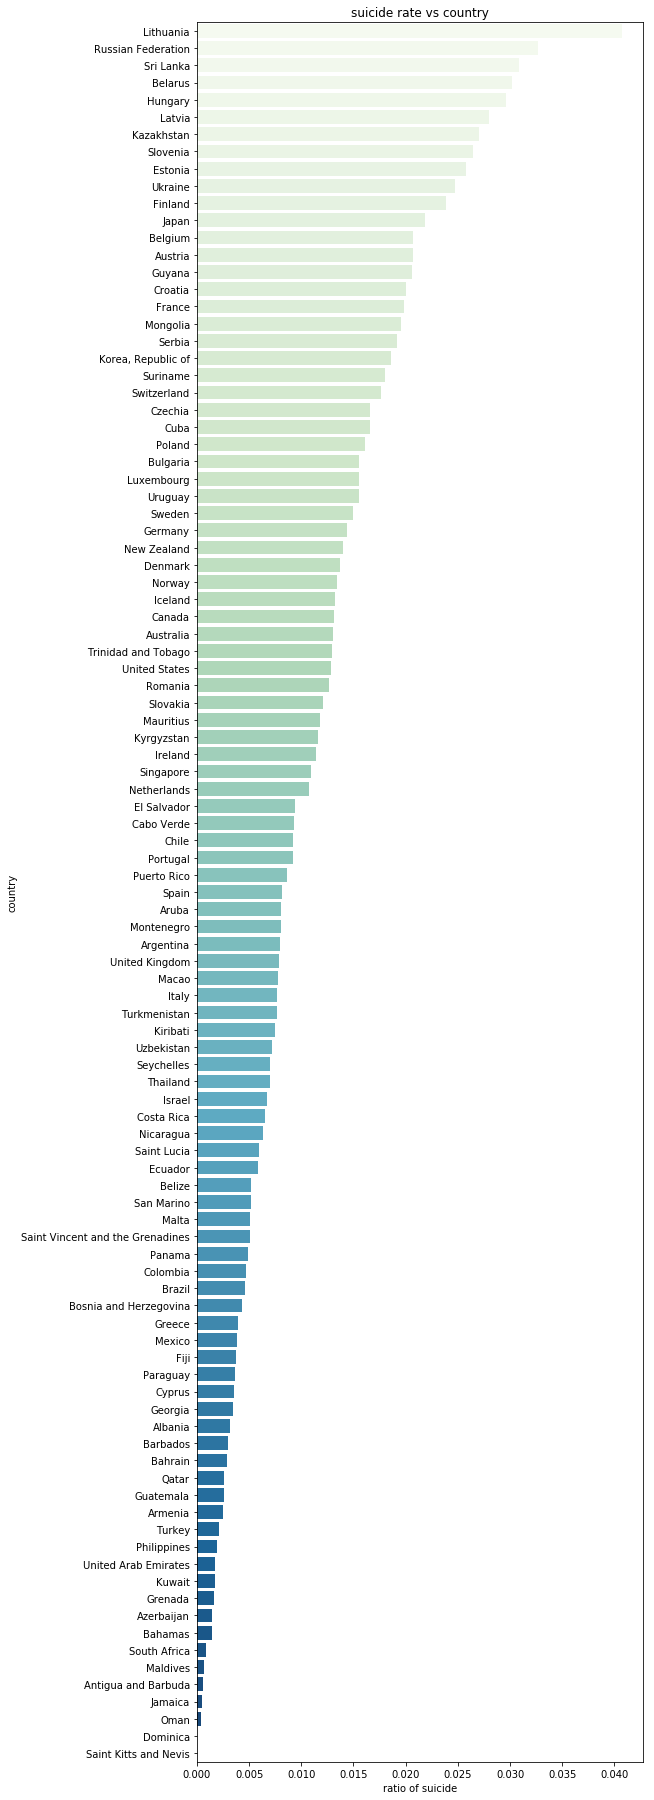

In [15]:
plt.figure(figsize=(8,32))
sns.barplot(x=country_suicide[:],y=country_list[:], palette="GnBu")
plt.xlabel("ratio of suicide")
plt.ylabel("country")
plt.title("suicide rate vs country")
plt.show()

Then we replace the keys of dictionary with alpha3 country code.

In [16]:
country_dict = dict()
for idx in range(len(country_list)):
    country_dict[countries[country_list[idx]]] = country_suicide[idx]

Define a new dataframe. The columns are country code and suicide rate.

In [17]:
new_country_dict = {}
new_country_dict["iso_a3"] = list(country_dict.keys())
new_country_dict["suicide_rate"] = list(country_dict.values())
new_country_df = pd.DataFrame(new_country_dict)
new_country_df.head()

,iso_a3,suicide_rate
0,LTU,0.040736
1,RUS,0.032703
2,LKA,0.030848
3,BLR,0.030231
4,HUN,0.029617


Use geopandas library to get information of countries, including coordinate.

In [18]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


Merge two dataframe together.

In [19]:
result = pd.merge(world, new_country_df, on = "iso_a3")
result.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,suicide_rate
0,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",0.003137
1,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",0.001751
2,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,0.007911
3,2967004.0,Asia,Armenia,ARM,18770.0,"POLYGON ((43.58274580259273 41.09214325618257,...",0.002475
4,21262641.0,Oceania,Australia,AUS,800200.0,(POLYGON ((145.3979781434948 -40.7925485166058...,0.013013


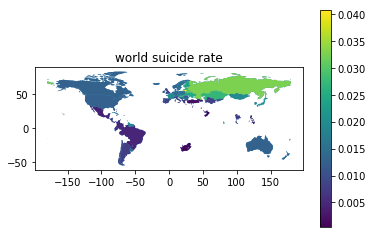

In [20]:
ax = result.plot()
ax.set_title("world suicide rate")
result.plot(column='suicide_rate', ax = ax, legend=True)

For top 10, seven tenth were former Soviet Union countries, located in eastern europe and Russia. Japan and Korea are also high-suicide-rate countries. Let's talk about the disintegration of Soviet Union.

Firstly, see what happened to the suicide rate year by year.

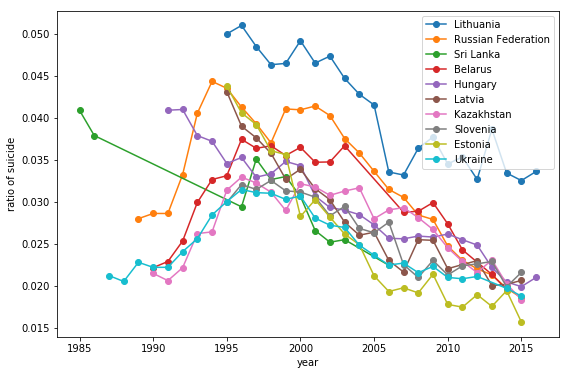

In [21]:
plt.figure(figsize = (9,6))
for country in country_list[:10]:
    plt.plot(df_total[country].index,df_total[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("ratio of suicide")
plt.legend()
plt.show()

It's clearly that the suicide rate of some top10 countries dramatically increased after 1990. In addition, the rate in others are still high during 1990 to 2000. The transition to the economy and democracy in former Soviet Union countries may be the main reasons. Although there have been numerous studies of the increase in mortality, such as alcoholism, economic hardship, despression and so on, but there is still no one accepted as the most significant factor of the mortality crisis. Let's find out.

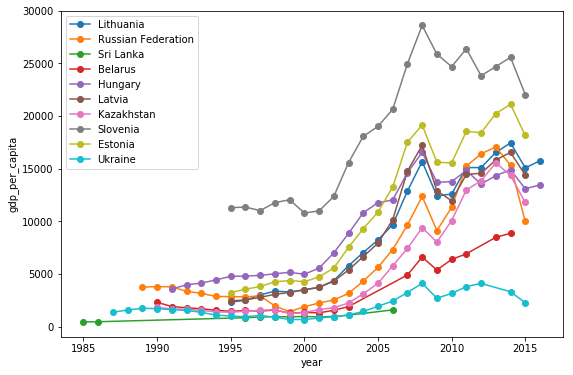

In [22]:
plt.figure(figsize = (9,6))
df_gdp = df.groupby(["country","year"]).gdp_per_capita.mean()
for country in country_list[:10]:
    plt.plot(df_gdp[country].index,df_gdp[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("gdp_per_capita")
plt.legend()
plt.show()

From this image we can see that the gdp_per_capita has no differece during 1990 to 2000. In other words, the economic situation were remain stagnant and  some countries got worse until 2002, after 2005, all countries' gdp start growing. 

We also know that the whole gdp_per_capita dropped within 2008 because of the financial crisis.  However, these ratio were still better than that before 2000. To see the relationship between suicide rate and gdp_per_capita, we plot the regression plot of two parameters. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


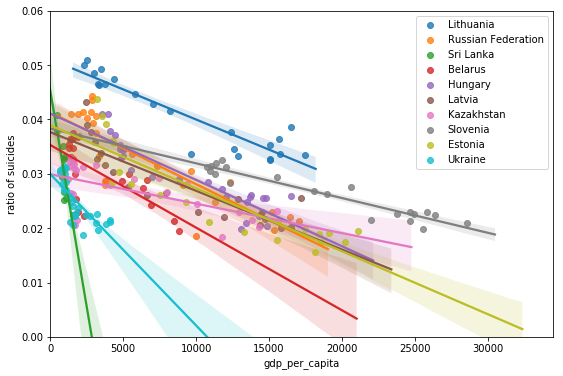

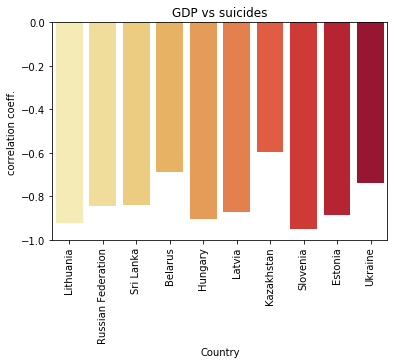

In [23]:
plt.figure(figsize = (9,6))
for country in country_list[:10]:
    sns.regplot(x=df_gdp[country].values, y=df_total[country].values, label = country)
plt.xlabel("gdp_per_capita")
plt.ylabel("ratio of suicides")
plt.ylim(0,0.06)
plt.xlim(0)
plt.legend()
plt.show()

corr_eff = {}
for country in country_list[:10]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation coeff.")
plt.title("GDP vs suicides")
plt.show()

Amazing! The suicide rate is highly correlated to the gdp_per_capita of top10 countries. Let's find out whether others have the same trend. 


/opt/conda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/opt/conda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/conda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


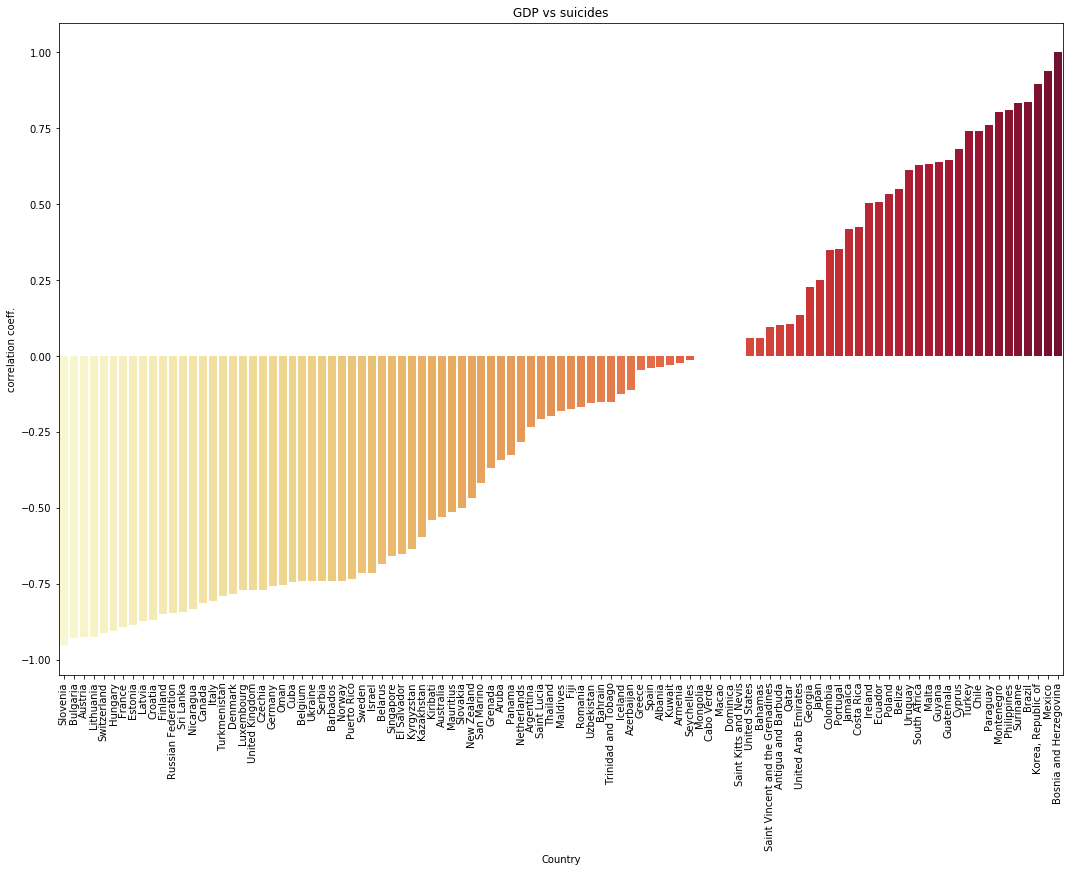

In [24]:
corr_eff = {}
p_value_eff = {}
for country in country_list[:]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values, df_total[country].values)
    corr_eff[country] = float(r_value)
    p_value_eff[country] = float(p_value)

gdp_tup = list(corr_eff.items())
gdp_tup.sort(key= lambda pair:pair[1], reverse = False)
dgp_relation = {a[0]:a[1] for a in gdp_tup}

plt.figure(figsize=(18,12))
sns.barplot(x=list(dgp_relation.keys()), y=list(dgp_relation.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation coeff.")
plt.title("GDP vs suicides")
plt.show()

Lots of countries' suicide rate are negatively high related to gdp_per_capita, but there are some countries have opposite outcome. It's impressive.

Next, we calculate how many countries with correlation coefficient below -0.6 . 

In [25]:
high_relation_gdp = {a:b for a,b in dgp_relation.items() if b <= -0.6}
print(len(high_relation_gdp))
high_relation_gdp

36


{'Slovenia': -0.9529455791278115,
 'Bulgaria': -0.9287679102475701,
 'Austria': -0.9259200512084546,
 'Lithuania': -0.9239757987267332,
 'Switzerland': -0.9109503853299822,
 'Hungary': -0.9040354533627301,
 'France': -0.891033016219988,
 'Estonia': -0.8871441228139314,
 'Latvia': -0.8730699831833395,
 'Croatia': -0.8688905854455011,
 'Finland': -0.8510603475107353,
 'Russian Federation': -0.8447320241371793,
 'Sri Lanka': -0.8423723520534465,
 'Nicaragua': -0.8339461195785591,
 'Canada': -0.8137269827924933,
 'Italy': -0.8058989652804354,
 'Turkmenistan': -0.789798470389873,
 'Denmark': -0.785030750255649,
 'Luxembourg': -0.7712677174711061,
 'United Kingdom': -0.7709229981372079,
 'Czechia': -0.7706689026781656,
 'Germany': -0.7567584036061585,
 'Oman': -0.7547353920453065,
 'Cuba': -0.7437036777206897,
 'Belgium': -0.7416790406841788,
 'Ukraine': -0.7413562367777868,
 'Serbia': -0.7411928190991895,
 'Barbados': -0.7409526707249006,
 'Norway': -0.7406431335510837,
 'Puerto Rico': -0.7

About one third countries have high relationship with gdp_per_capita. We can say that gdp is another reason of high suicide rate.

Following are the countries which relation coefficient are higher than 0.6 .

In [26]:
positive_relation_gdp = {a:b for a,b in corr_eff.items() if b > 0.6}
positive_relation_tup = list(positive_relation_gdp.items())
positive_relation_tup.sort(key= lambda pair:pair[1], reverse = True)
positive_relation = {a[0]:a[1] for a in positive_relation_tup}
print(len(positive_relation))
positive_relation

16


{'Bosnia and Herzegovina': 0.9999999999999999,
 'Mexico': 0.9392731898535472,
 'Korea, Republic of': 0.8967892885653613,
 'Brazil': 0.8356111067311864,
 'Suriname': 0.8333078326024657,
 'Philippines': 0.8099497394094539,
 'Montenegro': 0.8042382321252367,
 'Paraguay': 0.7599968993976424,
 'Chile': 0.7412265208253951,
 'Turkey': 0.7398789818429371,
 'Cyprus': 0.6812947745988278,
 'Guatemala': 0.6460477591267608,
 'Guyana': 0.6379567025207803,
 'Malta': 0.6334189190517482,
 'South Africa': 0.6287573335302014,
 'Uruguay': 0.61206046817105}

Let's take a look at suicide rate and gdp_per_capita of these countries.

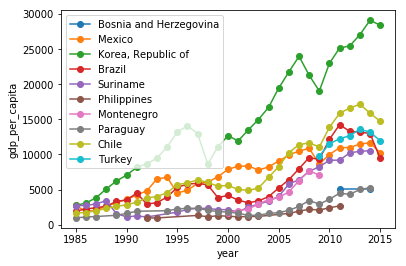

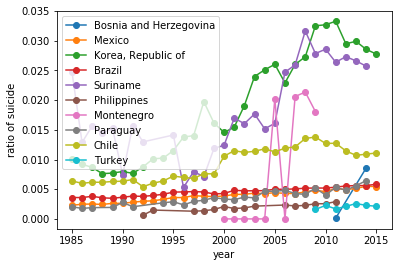

In [27]:
city_list = list({a:b for a,b in positive_relation.items()})
for country in city_list[:10]:
    plt.plot(df_gdp[country].index,df_gdp[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("gdp_per_capita")
plt.legend()
plt.show()

for country in city_list[:10]:
    plt.plot(df_total[country].index,df_total[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("ratio of suicide")
plt.legend()
plt.show()

It's weird that the gdp_per_capita and suicide rate of Korea are growing faster. Does it mean that there are social problems that cause the situation like that!? 

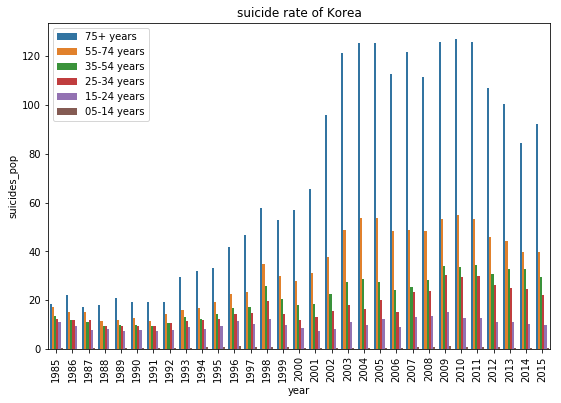

In [28]:
plt.figure(figsize = (9,6))
sns.barplot(x="year", y="suicides_pop", hue="age",
            ci = None,data = (df[df["country"] == "Korea, Republic of"]) )
plt.xticks(rotation = 90)
plt.title("suicide rate of Korea" )
plt.legend()    
plt.show()

What's going on with old people in Korea!? After 2000, the suicide rate of people over 75 years old is almost double. Was Korea society not friendly to the old people or the enviroment depressed the old people? As we mentioned early, age is a factor of high suicide rate. A country should setup social welfare to take care of old people just in case.

On the other hand, the rate of people whose age is over 24 are growing after 1992. This phenomenon reflects the increasing burden on society, like salary,  academic pressure, family and so on.

Last but not least, how about the countries with high suicide rate not related to the gdp_per_capita!? Let's see which countries meet the condition.

In [29]:
without_relation_gdp = {a:b for a,b in corr_eff.items() if -0.3 < b < 0.3}
no_relation_gdp = [i for i in country_list[:20] if i in without_relation_gdp.keys()]
no_relation_gdp

['Japan', 'Mongolia']

Plot the age structure of Japan.

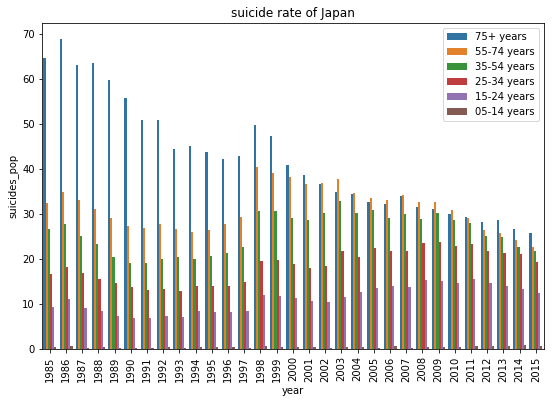

In [30]:
plt.figure(figsize = (9,6))
sns.barplot(x="year", y="suicides_pop", hue="age",
            ci = None,data = (df[df["country"] == "Japan"]) )
plt.xticks(rotation = 90)
plt.title("suicide rate of Japan" )
plt.legend()    
plt.show()

Although the suicide rate of the elderly has improved, the rate of young people is still not low. This shows that the social pressure haven't been relieved.

## Conclusion
In general, the suicide rate is related to several factors. First, national GDP per person. We have seen that the suicide rate in many countries is highly correlated with the gdp of the whole country, which shows that the degree of national wealth has a certain degree of reduction in suicide rate.

Second, the age. According to the suicide rate of each level of age, the rate of elderly is higher, so young people should care more about the elderly. Moreover, the country welfare of the elderly may also impact the rate.

Third, the social pressure. A healthy society can make citizens feel safe and satisfied, so how to relieve the social pressure becomes a significant topic for every country. Our purpose is not only reduce the suicide rate but also to build a better world.